### Playing Gridworld using Actor/Critic

#### Introduction

This tutorial builds off of [Outlace's excelent blog entry on Q-Learning](http://outlace.com/Reinforcement-Learning-Part-3/) and this is the [starting point](https://www2.informatik.uni-hamburg.de/~weber/code/ActorCritic.py) for the Actor Critic implementation.

 The new paper [Asynchronous Methods for Deep Reinforcement Learning](http://arxiv.org/abs/1602.01783) uses an Actor/Critic learning implementation to surpass the performance of their original Deep Q-Network.

For a slightly more in-depth explanation check out [Actor-Critic Methods](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node66.html) from the book 'Reinforcement Learning: An Introduction' by Sutton and Barto


# Our Gridworld

This is the gridworld implementation from [the original Q-learning tutorial](http://outlace.com/Reinforcement-Learning-Part-3/) which we will use as the environment for our Actor/Critic learner. One small tweak we made is to end the episode if the Agent has made more than 40 moves but still hasn't made it to a terminal state.

In [ ]:
### IMPORTS ###

from IPython.display import clear_output
import random
import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%pylab inline

# This is added - implicitly limit move count.
MAX_MOVES=40
move_counter = 0

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

#finds an array in the "depth" dimension of the grid
def findLoc(state, obj):
    for i in range(0,4):
        for j in range(0,4):
            if (state[i,j] == obj).all():
                return i,j

#Initialize stationary grid, all items are placed deterministically
def initGrid():
    global move_counter
    move_counter = 0
    state = np.zeros((4,4,4))
    #place player
    state[0,1] = np.array([0,0,0,1])
    #place wall
    state[2,2] = np.array([0,0,1,0])
    #place pit
    state[1,1] = np.array([0,1,0,0])
    #place goal
    state[3,3] = np.array([1,0,0,0])

    return state

#Initialize player in random location, but keep wall, goal and pit stationary
def initGridPlayer():
    global move_counter
    move_counter = 0
    state = np.zeros((4,4,4))
    #place player
    state[randPair(0,4)] = np.array([0,0,0,1])
    #place wall
    state[2,2] = np.array([0,0,1,0])
    #place pit
    state[1,1] = np.array([0,1,0,0])
    #place goal
    state[1,2] = np.array([1,0,0,0])

    a = findLoc(state, np.array([0,0,0,1])) #find grid position of player (agent)
    w = findLoc(state, np.array([0,0,1,0])) #find wall
    g = findLoc(state, np.array([1,0,0,0])) #find goal
    p = findLoc(state, np.array([0,1,0,0])) #find pit
    if (not a or not w or not g or not p):
        #print('Invalid grid. Rebuilding..')
        return initGridPlayer()

    return state

#Initialize grid so that goal, pit, wall, player are all randomly placed
def initGridRand():
    global move_counter
    move_counter = 0
    state = np.zeros((4,4,4))
    #place player
    state[randPair(0,4)] = np.array([0,0,0,1])
    #place wall
    state[randPair(0,4)] = np.array([0,0,1,0])
    #place pit
    state[randPair(0,4)] = np.array([0,1,0,0])
    #place goal
    state[randPair(0,4)] = np.array([1,0,0,0])

    a = findLoc(state, np.array([0,0,0,1]))
    w = findLoc(state, np.array([0,0,1,0]))
    g = findLoc(state, np.array([1,0,0,0]))
    p = findLoc(state, np.array([0,1,0,0]))
    #If any of the "objects" are superimposed, just call the function again to re-place
    if (not a or not w or not g or not p):
        #print('Invalid grid. Rebuilding..')
        return initGridRand()

    return state

def makeMove(state, action):
    #need to locate player in grid
    #need to determine what object (if any) is in the new grid spot the player is moving to
    player_loc = findLoc(state, np.array([0,0,0,1]))
    wall = findLoc(state, np.array([0,0,1,0]))
    goal = findLoc(state, np.array([1,0,0,0]))
    pit = findLoc(state, np.array([0,1,0,0]))
    state = np.zeros((4,4,4))

    #up (row - 1)
    if action==0:
        new_loc = (player_loc[0] - 1, player_loc[1])
        if (new_loc != wall):
            if ((np.array(new_loc) <= (3,3)).all() and (np.array(new_loc) >= (0,0)).all()):
                state[new_loc][3] = 1
    #down (row + 1)
    elif action==1:
        new_loc = (player_loc[0] + 1, player_loc[1])
        if (new_loc != wall):
            if ((np.array(new_loc) <= (3,3)).all() and (np.array(new_loc) >= (0,0)).all()):
                state[new_loc][3] = 1
    #left (column - 1)
    elif action==2:
        new_loc = (player_loc[0], player_loc[1] - 1)
        if (new_loc != wall):
            if ((np.array(new_loc) <= (3,3)).all() and (np.array(new_loc) >= (0,0)).all()):
                state[new_loc][3] = 1
    #right (column + 1)
    elif action==3:
        new_loc = (player_loc[0], player_loc[1] + 1)
        if (new_loc != wall):
            if ((np.array(new_loc) <= (3,3)).all() and (np.array(new_loc) >= (0,0)).all()):
                state[new_loc][3] = 1

    new_player_loc = findLoc(state, np.array([0,0,0,1]))
    if (not new_player_loc):
        state[player_loc] = np.array([0,0,0,1])
    #re-place pit
    state[pit][1] = 1
    #re-place wall
    state[wall][2] = 1
    #re-place goal
    state[goal][0] = 1
    global move_counter
    move_counter += 1

    return state

def getLoc(state, level):
    for i in range(0,4):
        for j in range(0,4):
            if (state[i,j][level] == 1):
                return i,j

def getReward(state):
    player_loc = getLoc(state, 3)
    pit = getLoc(state, 1)
    goal = getLoc(state, 0)
    if (player_loc == pit):
        return -10
    elif (player_loc == goal):
        return 10
    elif (move_counter > MAX_MOVES):
        return -9
    else:
        return -1

def dispGrid(state):
    grid = np.zeros((4,4), dtype='<U2')
    player_loc = findLoc(state, np.array([0,0,0,1]))
    wall = findLoc(state, np.array([0,0,1,0]))
    goal = findLoc(state, np.array([1,0,0,0]))
    pit = findLoc(state, np.array([0,1,0,0]))
    for i in range(0,4):
        for j in range(0,4):
            grid[i,j] = ' '

    if player_loc:
        grid[player_loc] = 'P' #player
    if wall:
        grid[wall] = 'W' #wall
    if goal:
        grid[goal] = '+' #goal
    if pit:
        grid[pit] = '-' #pit

    return grid


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
state = initGrid()
dispGrid(state)

array([[' ', 'P', ' ', ' '],
       [' ', '-', ' ', ' '],
       [' ', ' ', 'W', ' '],
       [' ', ' ', ' ', '+']], dtype='<U2')

Try moving our player into the winning position.

In [ ]:
LEFT=2
RIGHT=3
UP=0
DOWN=1
A2S=['up','down','left','right']
state = initGrid()
state = makeMove(state, RIGHT)
state = makeMove(state, RIGHT)
state = makeMove(state, DOWN)
state = makeMove(state, DOWN)
state = makeMove(state, DOWN)
print('Reward: %s' % (getReward(state),))
dispGrid(state)


Reward: 10


array([[' ', ' ', ' ', ' '],
       [' ', '-', ' ', ' '],
       [' ', ' ', 'W', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

# The Actor

In Actor/Critic there are two networks. The 'policy' network (the Actor) and the 'value' network (the Critic). You will recognize the policy network as being essentially the same as the network from the Q-Learning example.

In [ ]:
### IMPORTS ###
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation
# from keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop


2024-04-14 20:01:04.904035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 20:01:08.487511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:



actor_model = Sequential()
actor_model.add(Dense(164, kernel_initializer='lecun_uniform', input_shape=(64,)))
actor_model.add(Activation('relu'))

actor_model.add(Dense(150, kernel_initializer='lecun_uniform'))
actor_model.add(Activation('relu'))

actor_model.add(Dense(4, kernel_initializer='lecun_uniform'))
actor_model.add(Activation('linear'))

rms = RMSprop()
actor_model.compile(loss='mse', optimizer=rms)


/mnt/beegfs/home/avallala2023/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-14 20:01:13.203682: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Next, we set up the Critic network. This network looks very similar to the Actor model, but only outputs a single value - it outputs a value (the score) for the input state.

In [ ]:



critic_model = Sequential()

critic_model.add(Dense(256, kernel_initializer='lecun_uniform', input_shape=(64,)))
critic_model.add(Activation('relu'))

critic_model.add(Dense(128, kernel_initializer='lecun_uniform'))
critic_model.add(Activation('relu'))

critic_model.add(Dense(64, kernel_initializer='lecun_uniform'))
critic_model.add(Activation('relu'))

# For the output layer, add the activation within the Dense layer
critic_model.add(Dense(1, kernel_initializer='lecun_uniform', activation='linear'))

rms = RMSprop()
critic_model.compile(loss='mse', optimizer=rms)


The 'test' stays essentially the same. It is important to note, that when testing, we only need the actor/policy network. The critic network is not involved. The Actor has learned the correct policy/moves as it trains on the values supplied by the critic network.

In [ ]:
def testAlgo( initial_state=initGrid() ):
    state = initial_state.copy()

    print("Initial State:")
    print(dispGrid(state))
    i = 0
    status = 1
    #while game still in progress
    while(status == 1):
        qval = actor_model.predict(state.reshape(1,64), batch_size=1)
        action = (np.argmax(qval)) #take action with highest Q-value
        print('Move #: %s; Taking action: %s' % (i, A2S[action]))
        state = makeMove(state, action)
        print(dispGrid(state))
        reward = getReward(state)
        if reward != -1:
            status = 0
            print("Reward: %s" % (reward,))
        i += 1 #If we're taking more than 10 actions, just stop, we probably can't win this game
        if (i > 10):
            print("Game lost; too many moves.")
            break

# The Trainer

The trainer is implemented below. Items of note.
* __early stopping__ the trainer implements early-stopping. If the game is winning a given percentage of the time (90% is the default) then the trainer will stop early. No point training any further.
* __experience replay__ essentially the same as the example in the Q-learning tutorial. However we replay both the Actor and the Critic's experiences

The big main new things here are the split of the Critic network, and state values, from the Actor, and action selection.

To train the critic network, we use a simlar process to training value into Q networks. We look at the initial state, make a move, and then look at the new state. For the value network, if we are in a terminal state, that's the value we tell the value network to place on that state. If we are in a non-terminal state, we tell the value network to place a value on the original state which is the reward in the original state, plus the discounted value from the new state. Note that the value network should return the maximum possible value for a given state. If the player's next move could be either jumping into the pit or arriving at the goal, we should set the value as if the best-possible action will be selected.

After the critic network has assigned a value to the original and the new state, we adjust the policy. This is simply by looking at our value in our old state, and the value in the new state. If the value improves we encourage that action. If it decreases we discourage the action.

When we start training, both the actor and the critic networks are spitting out nonsensical values. Which means initially the actor network is training on values from the critic network which are garbage. However as the critic network improves, those improvements naturally correct and improve the performance of the actor network.



In [ ]:
def trainer(game_type='easy',epochs=1000, batchSize=40,
            gamma=0.9, epsilon=1, min_epsilon=0.1,
            buffer=80,earlystop=0.99):

    status = 1

    # Early-stopping.
    earlystop_acc = 0.0
    earlystop_decay = 0.9

    # Replay buffers
    actor_replay = []
    critic_replay = []

    #Losses
    actor_losses = []
    critic_losses = []

      # Weight trajectories
    actor_node_weights = []  # Initialize list to store actor weights
    critic_node_weights = []

    #Game Wins;
    game_wins = []

    for i in range(epochs):
        if game_type == 'hard':
            state = initGridRand()
        elif game_type == 'medium':
            state = initGridPlayer()
        else:
            state = initGrid() # easy

        status = 1
        #while game still in progress
        while(status == 1):
            # Get original state, original reward, and critic's value for this state.
            orig_state = np.copy(state)
            orig_reward = getReward(orig_state)
            orig_val = critic_model.predict(orig_state.reshape(1,64))

            if (random.random() < epsilon): #choose random action
                action = np.random.randint(0,4)
            else: #choose best action from Q(s,a) values
                qval = actor_model.predict( orig_state.reshape(1,64) )
                action = (np.argmax(qval))

            #Take action, observe new state S'
            new_state = makeMove(state, action)
            #Observe reward
            new_reward = getReward(new_state)

            # Critic's value for this new state.
            new_val = critic_model.predict(new_state.reshape(1,64))

            if new_reward == -1: # Non-terminal state.
                target = orig_reward + ( gamma * new_val)
            else:
                # In terminal states, the environment tells us
                # the value directly.
                target = orig_reward + ( gamma * new_reward )

            # For our critic, we select the best/highest value.. The
            # value for this state is based on if the agent selected
            # the best possible moves from this state forward.
            #
            # BTW, we discount an original value provided by the
            # value network, to handle cases where its spitting
            # out unreasonably high values.. naturally decaying
            # these values to something reasonable.
            best_val = max((orig_val*gamma), target)

            # Now append this to our critic replay buffer.
            critic_replay.append([orig_state,best_val])
            # If we are in a terminal state, append a replay for it also.
            if new_reward != -1:
                critic_replay.append( [new_state, float(new_reward)] )

            # Build the update for the Actor. The actor is updated
            # by using the difference of the value the critic
            # placed on the old state vs. the value the critic
            # places on the new state.. encouraging the actor
            # to move into more valuable states.
            actor_delta = new_val - orig_val
            actor_replay.append([orig_state, action, actor_delta])

            # Critic Replays...
            while(len(critic_replay) > buffer): # Trim replay buffer
                critic_replay.pop(0)
            # Start training when we have enough samples.
            if(len(critic_replay) >= buffer):
                minibatch = random.sample(critic_replay, batchSize)
                X_train = []
                y_train = []
                for memory in minibatch:
                    m_state, m_value = memory
                    y = np.empty([1])
                    y[0] = m_value
                    X_train.append(m_state.reshape((64,)))
                    y_train.append(y.reshape((1,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                #critic_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
                critic_history = critic_model.fit(X_train, y_train, batch_size=batchSize, epochs=1, verbose=0)
                critic_losses.extend(critic_history.history['loss'])
#                 critic_node_weights.append(critic_model.get_weights()[0][0, 0])



            # Actor Replays...
            while(len(actor_replay) > buffer):
                actor_replay.pop(0)
            if(len(actor_replay) >= buffer):
                X_train = []
                y_train = []
                minibatch = random.sample(actor_replay, batchSize)
                for memory in minibatch:
                    m_orig_state, m_action, m_value = memory
                    old_qval = actor_model.predict( m_orig_state.reshape(1,64,) )
                    y = np.zeros(( 1, 4 ))
                    y[:] = old_qval[:]
                    # non-standard - decay actions we aren't selecting on this turn.
                    #y[:] = old_qval[:] * gamma
                    y[0][m_action] = m_value
                    X_train.append(m_orig_state.reshape((64,)))
                    y_train.append(y.reshape((4,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                #actor_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
                actor_history = actor_model.fit(X_train, y_train, batch_size=batchSize, epochs=1, verbose=0)
                actor_losses.extend(actor_history.history['loss'])
#                 actor_node_weights.append(actor_model.get_weights()[0][0, 0])

            # Finished replays.

            state = new_state
            if new_reward != -1:
                status = 0
                # Count wins/losses for early-stopping.
                if new_reward == 10: # Win
                    earlystop_result = 1.0
                else: # Loss
                    earlystop_result = 0.0
                new_acc = ( earlystop_acc * earlystop_decay ) + \
                    ((1.0 - earlystop_decay ) * earlystop_result)
                earlystop_acc = new_acc



        # Finised Epoch
                    # End of epoch: record the current weight and loss
        actor_node_weights.append(actor_model.get_weights()[0][0, 0])  # first layer, first node weight
        critic_node_weights.append(critic_model.get_weights()[0][0, 0])
        clear_output(wait=True)
        print("Game #: %s" % (i,))
        print("Accumulated win percent: %.2f%%" % (earlystop_acc*100) )

        game_wins.append(earlystop_acc*100)

        if epsilon > min_epsilon:
            epsilon -= (1/epochs)
        # Check if we can early-stop training.
        if earlystop_acc > earlystop:
            print("Early-Stopping Training")
            break
    return actor_losses, critic_losses, actor_node_weights, critic_node_weights, game_wins


In [ ]:
def plot_value(initial_state):
    np_w_cri_r = np.zeros((4,4))
    # Remove player from initial state.
    working_state = initial_state.copy()
    p = findLoc(working_state, np.array([0,0,0,1]))
    working_state[p[0],p[1]] = np.array([0,0,0,0])
    for x in range(0,4):
        for y in range(0,4):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y,3] = 1
            # And now have the critic model predict the state value
            # with the player in that location.
            value = critic_model.predict(my_state.reshape(1, 64))
            #print("x,y: %s, %s - value %f" % (x, y, value) )
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()



We can see that the value network has placed a high value on the winning final position. That value equaling the reward gained when in that position. It also places a very low value on the 'pit' position. Makes sense. Then we can see that the network places ever growing value on positions which move us closer to the winning position. Thus the value network can express to the policy network that a move which moves us closer to the winning position is more valuable. Lets take a look at what the policy network has learned.

In [ ]:
A2A=['^','v','<','>']
def show_policy(initial_state):
    grid = np.zeros((4,4), dtype='<U2')
    working_state = initial_state.copy()
    p = findLoc(working_state, np.array([0,0,0,1]))
    working_state[p[0],p[1]] = np.array([0,0,0,0])
    for x in range(0,4):
        for y in range(0,4):
            #for a in range(0, 4):
            my_state = working_state.copy()
            my_state[x,y,3] = 1
            #
            qval = actor_model.predict(my_state.reshape(1, 64))
            action = (np.argmax(qval))
            grid[x,y] = A2A[action]
    return grid




Lets just dive into training on the easy variant.

In [ ]:
actor_losses, critic_losses, actor_node_weights, critic_node_weights,game_wins = trainer(game_type='easy',epochs=500,earlystop=0.90,min_epsilon=0.01)

Game #: 273
Accumulated win percent: 90.21%
Early-Stopping Training


 The training early-stops after acheving better than a 90% score. Well before 500 epochs are complete.

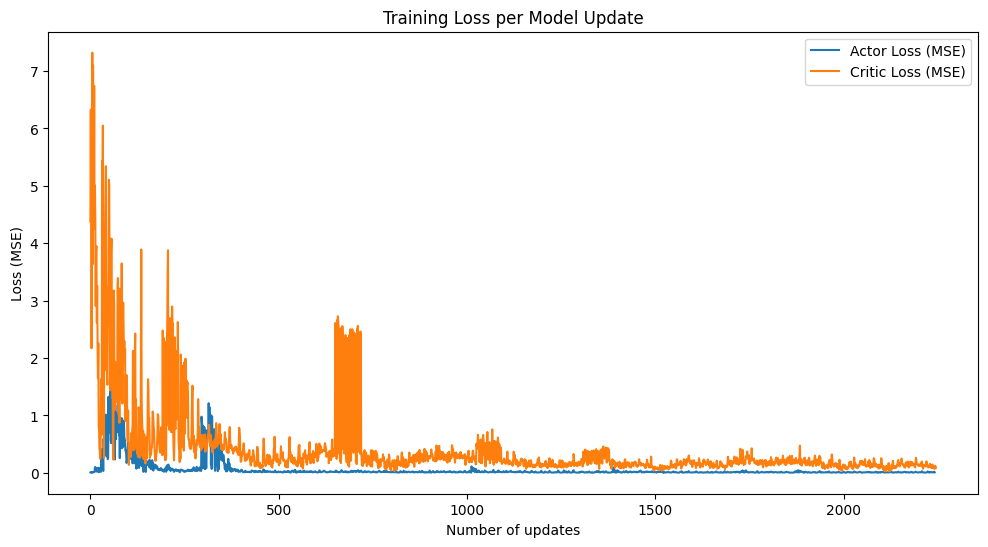

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actor_losses, label='Actor Loss (MSE)')
plt.plot(critic_losses, label='Critic Loss (MSE)')
plt.title('Training Loss per Model Update')
plt.xlabel('Number of updates')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

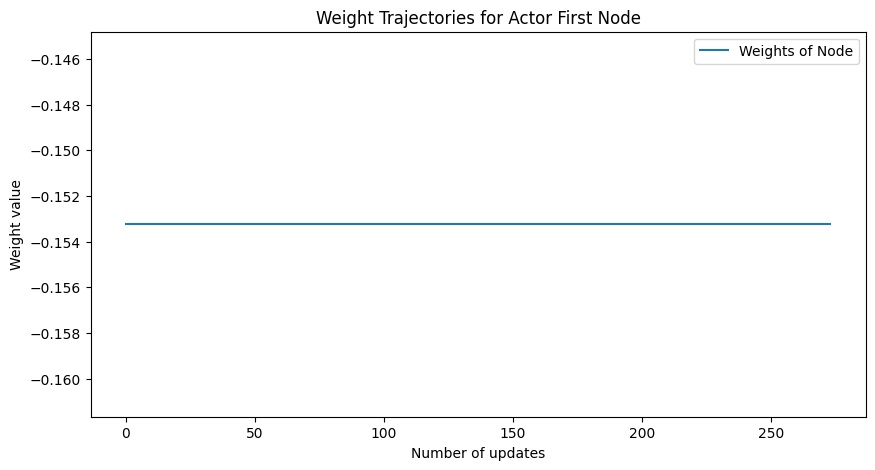

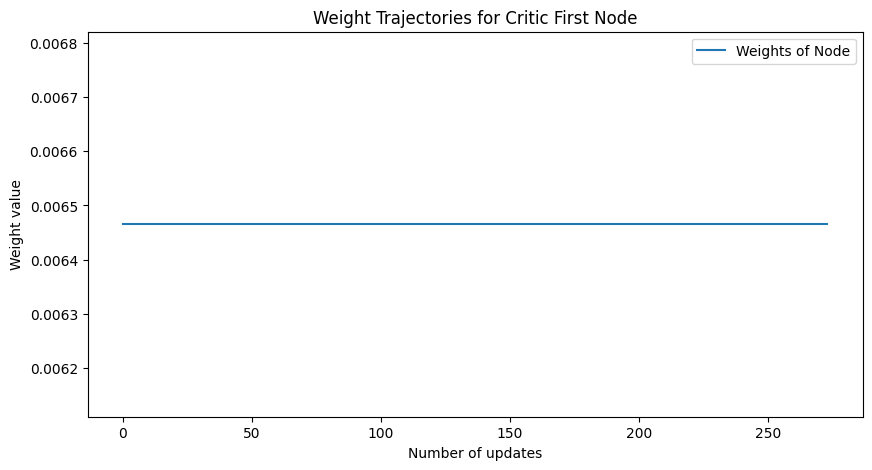

In [ ]:
def plot_node_weights(weights, title):
    epochs = len(weights)
    weights = np.array(weights)  # Convert list of arrays into a 2D numpy array

    plt.figure(figsize=(10, 5))
    plt.plot(weights, label=f'Weights of Node')
    plt.title(f'Weight Trajectories for {title}')
    plt.xlabel('Number of updates')
    plt.ylabel('Weight value')
    plt.legend()
    plt.show()

# Plotting for actor and critic for the specific node
plot_node_weights(actor_node_weights, 'Actor First Node')
plot_node_weights(critic_node_weights, 'Critic First Node')


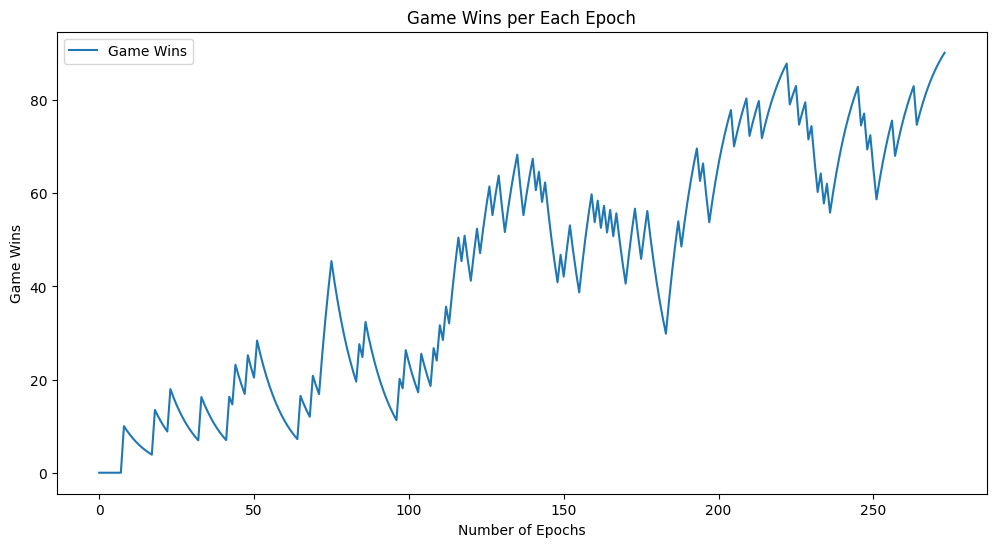

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(game_wins, label='Game Wins')
plt.title('Game Wins per Each Epoch')
plt.xlabel('Number of Epochs')
plt.ylabel('Game Wins')
plt.legend()
plt.show()

In [ ]:
easy_state = initGrid()
testAlgo(easy_state)

Initial State:
[[' ' 'P' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Move #: 0; Taking action: right
[[' ' ' ' 'P' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Move #: 1; Taking action: down
[[' ' ' ' ' ' ' ']
 [' ' '-' 'P' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Move #: 2; Taking action: right
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' 'P']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Move #: 3; Taking action: down
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' '+']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Move #: 4; Taking action: down
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Reward: 10


Now lets take a quick look at what our agent learned to solve this grid.

Board State:
[[' ' 'P' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' '+']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/tmp/ipykernel_262593/2764343355.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  np_w_cri_r[x,y] = value


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Policy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━

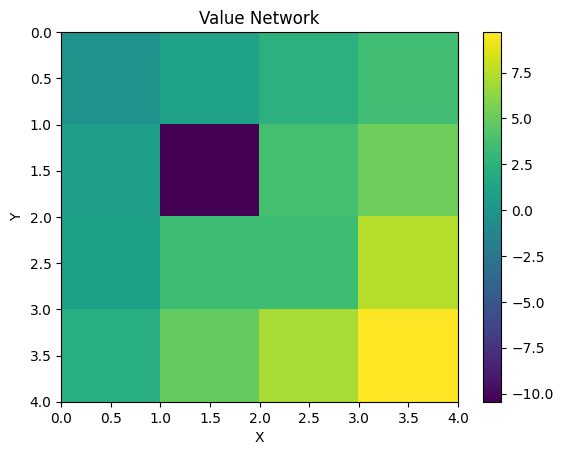

In [ ]:
print("Board State:")
print(dispGrid(easy_state))
plot_value(easy_state)
print("Policy")
print(show_policy(easy_state))

Lets just dive into training on the medium variant.

In [ ]:
actor_losses, critic_losses, actor_node_weights, critic_node_weights,game_wins = trainer(game_type='medium',epochs=300,earlystop=0.90,min_epsilon=0.01)

Game #: 150
Accumulated win percent: 90.31%
Early-Stopping Training


 The training early-stops after acheving better than a 90% score. Well before 500 epochs are complete.

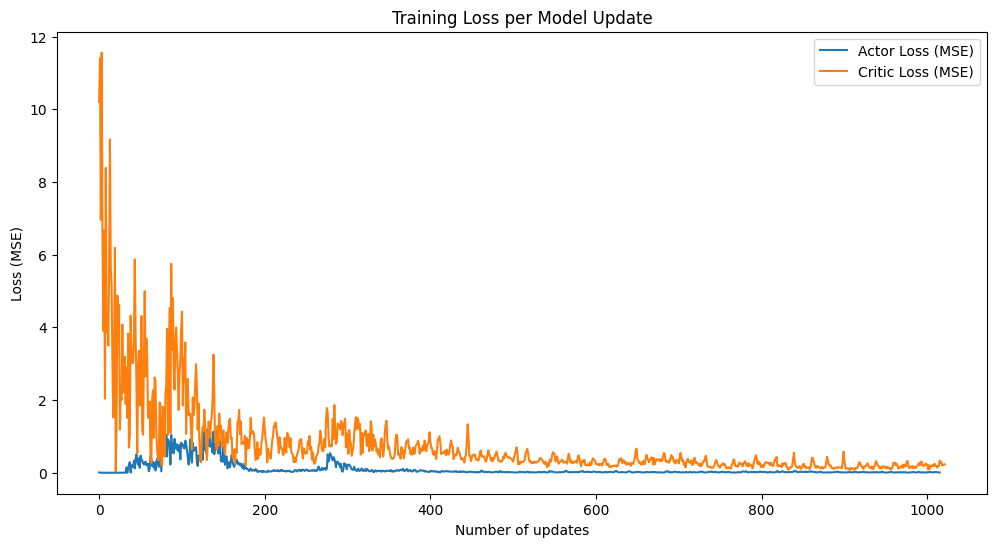

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actor_losses, label='Actor Loss (MSE)')
plt.plot(critic_losses, label='Critic Loss (MSE)')
plt.title('Training Loss per Model Update')
plt.xlabel('Number of updates')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

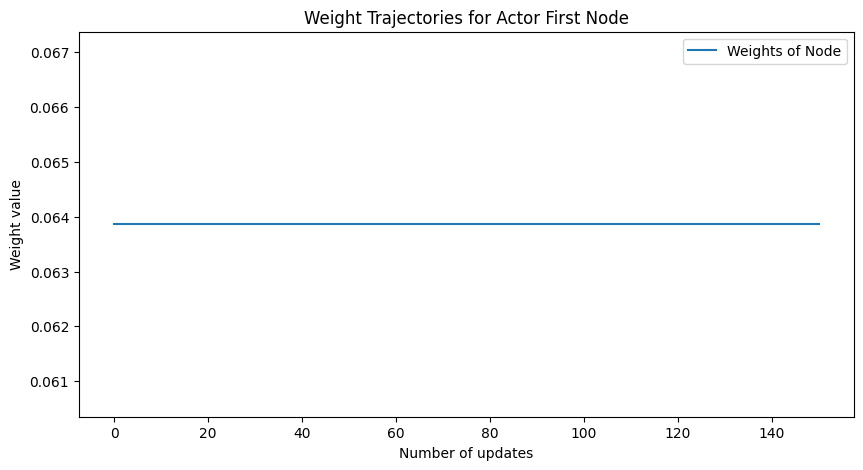

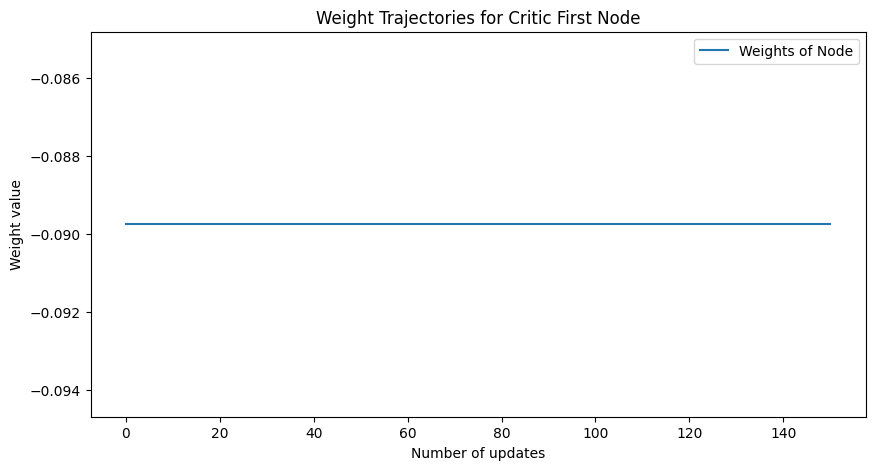

In [ ]:
import matplotlib.pyplot as plt

def plot_node_weights(weights, title):
    epochs = len(weights)
    weights = np.array(weights)  # Convert list of arrays into a 2D numpy array

    plt.figure(figsize=(10, 5))
    plt.plot(weights, label=f'Weights of Node')
    plt.title(f'Weight Trajectories for {title}')
    plt.xlabel('Number of updates')
    plt.ylabel('Weight value')
    plt.legend()
    plt.show()

# Plotting for actor and critic for the specific node
plot_node_weights(actor_node_weights, 'Actor First Node')
plot_node_weights(critic_node_weights, 'Critic First Node')


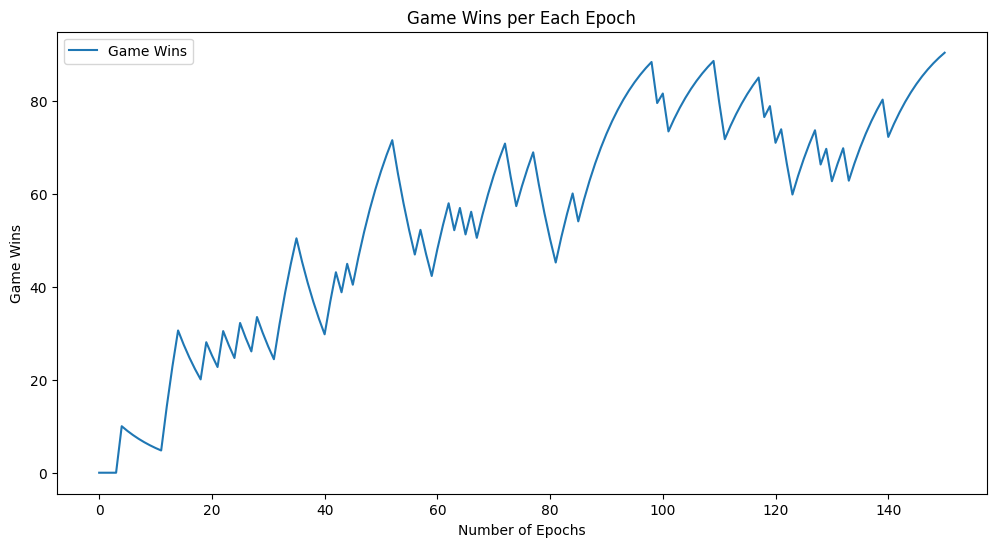

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(game_wins, label='Game Wins')
plt.title('Game Wins per Each Epoch')
plt.xlabel('Number of Epochs')
plt.ylabel('Game Wins')
plt.legend()
plt.show()

In [ ]:
medium_state = initGridPlayer()
testAlgo(medium_state)



Initial State:
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' 'P' 'W' ' ']
 [' ' ' ' ' ' '+']]
1/1 [==============================] - 0s 18ms/step
Move #: 0; Taking action: down
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' 'P' ' ' '+']]
1/1 [==============================] - 0s 16ms/step
Move #: 1; Taking action: right
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' 'P' '+']]
1/1 [==============================] - 0s 19ms/step
Move #: 2; Taking action: right
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Reward: 10


Now lets take a quick look at what our agent learned to solve this grid.

Board State:
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' 'P' 'W' ' ']
 [' ' ' ' ' ' '+']]
1/1 [==============================] - 0s 18ms/step


<ipython-input-11-d9c56409fe33>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  np_w_cri_r[x,y] = value


1/1 [==============================] - 0s 17ms/step
Policy
1/1 [==============================] - 0s 22ms/step
[['v' '>' 'v' 'v']
 ['v' 'v' '>' 'v']
 ['v' 'v' 'v' 'v']
 ['>' '>' '>' 'v']]


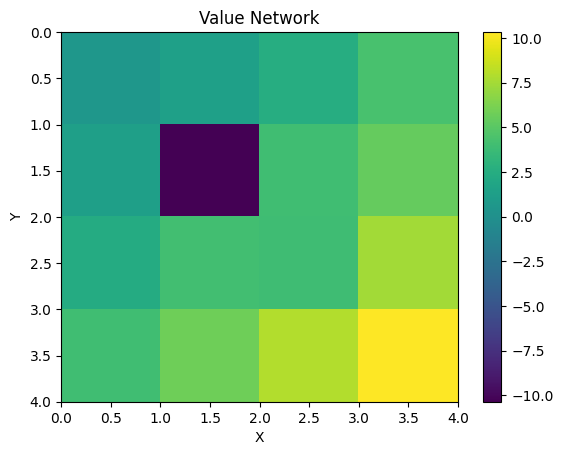

In [ ]:
print("Board State:")
print(dispGrid(medium_state))
plot_value(medium_state)
print("Policy")
print(show_policy(medium_state))


In [ ]:
actor_losses, critic_losses, actor_node_weights, critic_node_weights,game_wins = trainer(game_type='hard',epochs=1000,earlystop=0.90,min_epsilon=0.01)

Game #: 999
Accumulated win percent: 21.75%


 The training does not early-stop even after training for 1000 epochs

 The training early-stops after acheving better than a 90% score. Well before 500 epochs are complete.

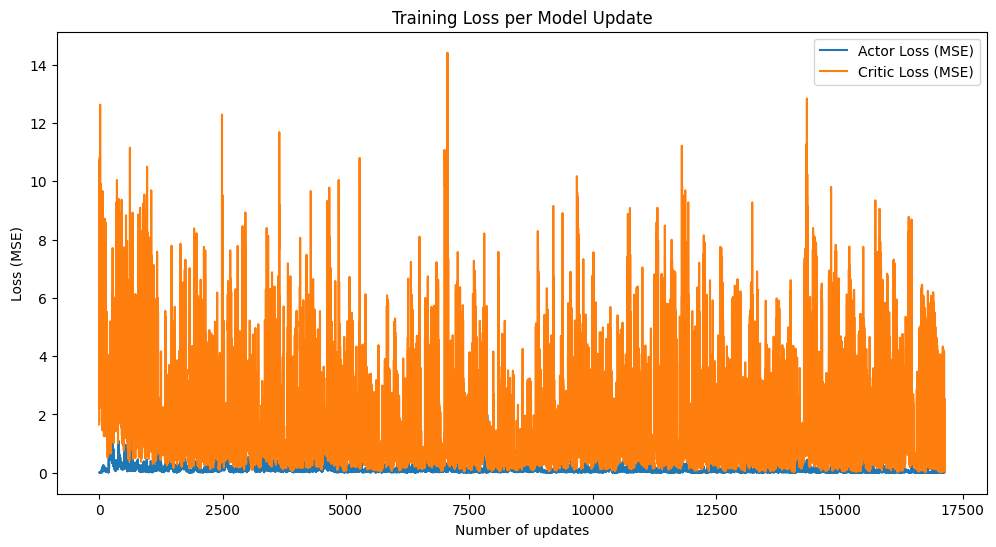

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actor_losses, label='Actor Loss (MSE)')
plt.plot(critic_losses, label='Critic Loss (MSE)')
plt.title('Training Loss per Model Update')
plt.xlabel('Number of updates')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

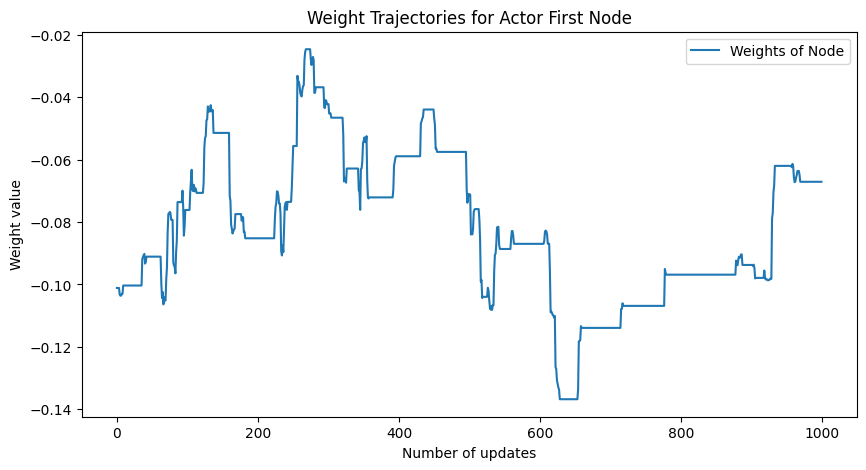

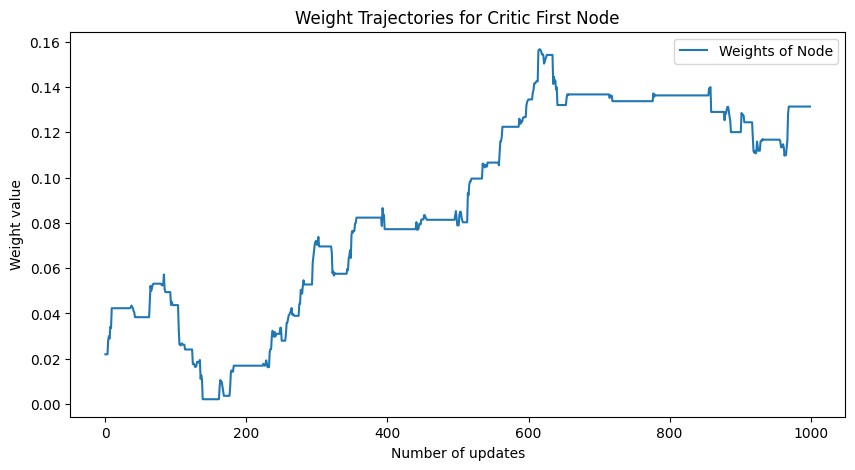

In [ ]:
def plot_node_weights(weights, title):
    epochs = len(weights)
    weights = np.array(weights)  # Convert list of arrays into a 2D numpy array

    plt.figure(figsize=(10, 5))
    plt.plot(weights, label=f'Weights of Node')
    plt.title(f'Weight Trajectories for {title}')
    plt.xlabel('Number of updates')
    plt.ylabel('Weight value')
    plt.legend()
    plt.show()

# Plotting for actor and critic for the specific node
plot_node_weights(actor_node_weights, 'Actor First Node')
plot_node_weights(critic_node_weights, 'Critic First Node')

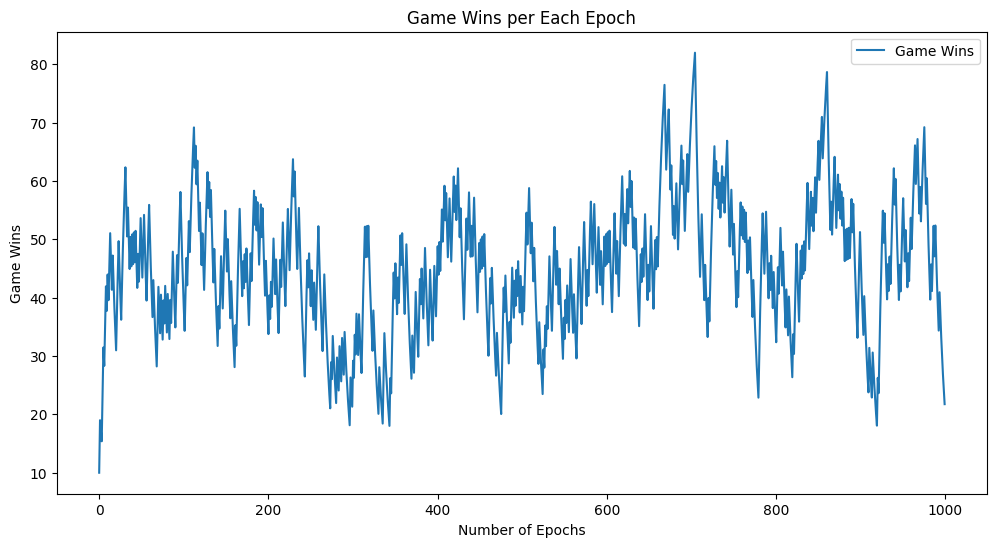

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(game_wins, label='Game Wins')
plt.title('Game Wins per Each Epoch')
plt.xlabel('Number of Epochs')
plt.ylabel('Game Wins')
plt.legend()
plt.show()

In [ ]:
hard_state = initGridRand()
testAlgo(hard_state)

Initial State:
[[' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' ' ']
 ['W' ' ' ' ' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Move #: 0; Taking action: right
[[' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' ' ']
 ['W' ' ' ' ' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Move #: 1; Taking action: down
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' '-' '+' ' ']
 ['W' ' ' ' ' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Move #: 2; Taking action: down
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' 'P']
 ['W' ' ' ' ' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Move #: 3; Taking action: up
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' '-' '+' ' ']
 ['W' ' ' ' ' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Move #: 4; Taking action: down
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' 'P']
 ['W' ' ' ' ' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Move #: 5; Taking action: up
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' '-' '+' ' ']
 ['W' ' ' ' ' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

Now lets take a quick look at what our agent learned to solve this grid.

Board State:
[[' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' '+' ' ']
 ['W' ' ' ' ' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/tmp/ipykernel_284226/53884726.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  np_w_cri_r[x,y] = value


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Policy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[['<'

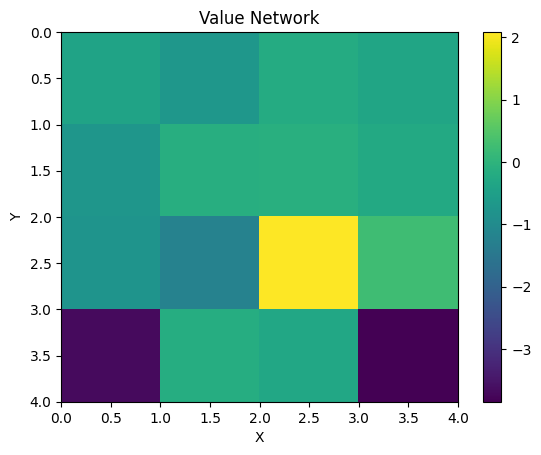

In [ ]:
print("Board State:")
print(dispGrid(hard_state))
plot_value(hard_state)
print("Policy")
print(show_policy(hard_state))

The agent can solve many random configurations of gridworld.. But there's some configurations which give it trouble. It seems to have a hard time with walls. Here's an example problematic grid configuration.

In [ ]:
def initGridEvil():
    global move_counter
    move_counter = 0
    state = np.zeros((4,4,4))
    #place player
    state[2,1] = np.array([0,0,0,1])
    #place wall
    state[3,1] = np.array([0,0,1,0])
    #place pit
    state[2,2] = np.array([0,1,0,0])
    #place goal
    state[3,2] = np.array([1,0,0,0])
    return state

grid_evil = initGridEvil()
#print(dispGrid(grid_evil))
testAlgo(grid_evil)

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'P' '-' ' ']
 [' ' 'W' '+' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Move #: 0; Taking action: left
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' '-' ' ']
 [' ' 'W' '+' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Move #: 1; Taking action: left
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' '-' ' ']
 [' ' 'W' '+' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Move #: 2; Taking action: left
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' '-' ' ']
 [' ' 'W' '+' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Move #: 3; Taking action: left
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' '-' ' ']
 [' ' 'W' '+' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Move #: 4; Taking action: left
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' '-' ' ']
 [' ' 'W' '+' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Move #: 5; Taking action: left
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' '-' ' ']
 [' ' 'W' '+' ' ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms

# Conclusion

Action-Critic Architecture has its place in Machine Learning and is very effective as a simple to learn and easy to use program.  This Actor-Critic Experiment highlights the usefulness of the network in training and Actor to navigate through a maze. The agent went from random exploration to specifically trained movements through purposeful navigation. Although it could not adapt to dynamically changing environments, further research can be done to enhance its ability in new locations, ultimately broadening its applicability to real-world problems, such as control of a human arm, or when walking on a cliff.

#Reference:

https://github.com/gregretkowski/notebooks/blob/master/gridworld-actor-critic.ipynb
